In [56]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [96]:
batch_size = 32
img_height = 200
img_width = 200
class_names = ["apis","bombus","other","polistes","scoliidae","sphecidae","vespa","vespula","xylocopa"]
n_classes = len(class_names)

In [77]:
image_directory = 'C:/Users/mreek/Documents/beedata/train'

In [87]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  image_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 54348 files belonging to 9 classes.
Using 43479 files for training.


In [105]:
batches = len(train_ds)

In [88]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 54348 files belonging to 9 classes.
Using 10869 files for validation.


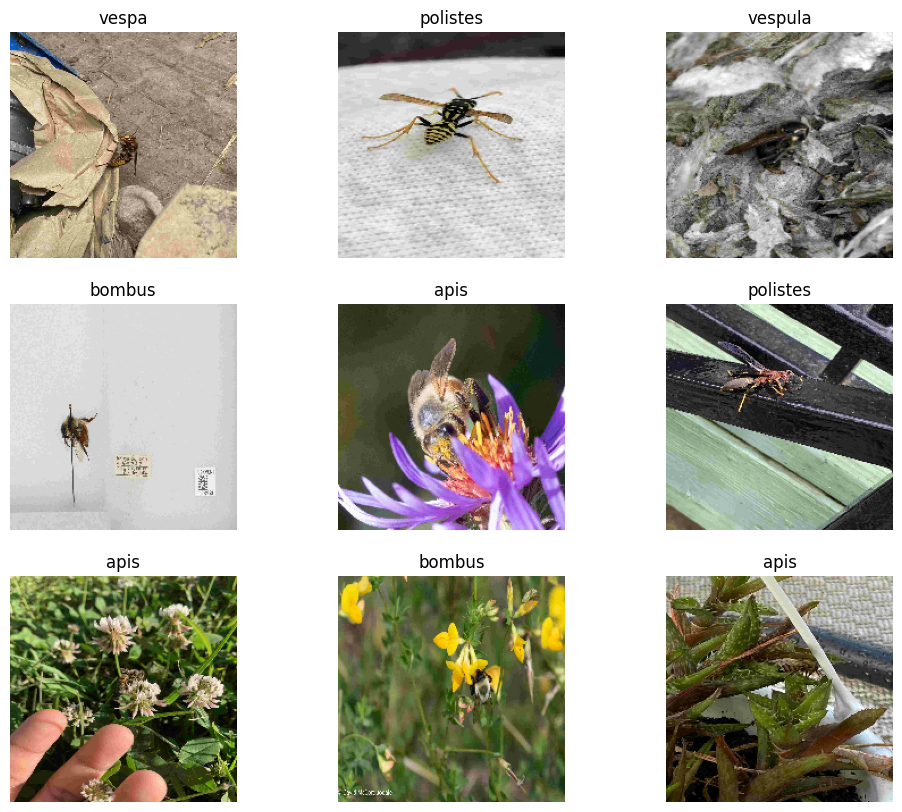

In [91]:
plt.figure(figsize=(12, 10))
index = 0
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [98]:
# def central_crop(image):
#     shape = tf.shape(image)
#     min_dim = tf.reduce_min([shape[0], shape[1]])
#     top_crop = (shape[0] - min_dim) // 4
#     bottom_crop = shape[0] - top_crop
#     left_crop = (shape[1] - min_dim) // 4
#     right_crop = shape[1] - left_crop
#     return image[top_crop:bottom_crop, left_crop:right_crop]

# def random_crop(image):
#     shape = tf.shape(image)
#     min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
#     return tf.image.random_crop(image, (min_dim, min_dim, 3))

# def preprocess(batch, labels, randomize=False):
#     for image in batch:
#         image = tf.ensure_shape(image, [200, 200, 3])
#         if randomize:
#             cropped_image = random_crop(image)
#             cropped_image = tf.image.random_flip_left_right(cropped_image)
#         else:
#             cropped_image = central_crop(image)
#         resized_image = tf.image.resize(cropped_image, [224, 224])
#         image = keras.applications.xception.preprocess_input(resized_image)
#     return batch, labels

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = keras.applications.xception.preprocess_input



train_set = train_ds.shuffle(30).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).prefetch(1)
valid_set = val_ds.map(preprocess).batch(batch_size).prefetch(1)
#test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [106]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()
inputs = base_model.input
prediction_layer = keras.layers.Dense(n_classes, activation="softmax")

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = avg(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = keras.models.Model(inputs=base_model.input, outputs=outputs)

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch=int(0.8 * batches),
                    validation_data=valid_set,
                    validation_steps=int(0.2 * batches),
                    epochs=5)

Epoch 1/5
 153/1087 [===>..........................] - ETA: 1:42:39 - loss: nan - accuracy: 0.1826

KeyboardInterrupt: 